In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [55]:
#specifying rolling window length
window = 21
#specifying maximum KPSS statistic (critical value); trade when KPSS < KPSS_max
KPSS_max = 0.463 # 95% = 0.463, 99% = 0.739 for unbiased(const); 95% = 0.146, 99% = 0.216 for biased(const+trend);tune for more conservative / lenient
#specifying the KPSS test (one-parameter unbiased or two-parameter) (unbiased algo, setting εt as 0, vary one para (const)/ non-unbiased algo, vary both para (const + trend)
unbiased = 1
#specifying whether to perform beta-loading or not
beta_loading = 1 # 0 equal weighted long/short pos; 1 adjust size position for long/short pair according to stockβ (ratio of $stock change to $market change)
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2019-09-28'
end = '2021-09-28'
#specifying the pair
tickers = ['XOM', 'CVX'] ###
#specifying the market index
market = '^GSPC'

In [56]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()

DF_stats = np.array([])
stock1 = tickers[0]
stock2 = tickers[1]

traded_dates = np.array([])

In [57]:
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


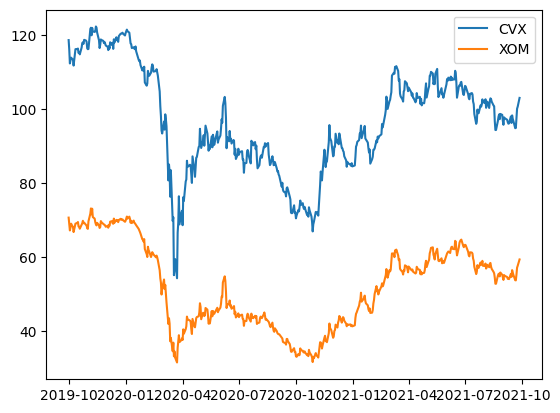

In [58]:
plt.plot(raw_data[stock2],label=stock2)
plt.plot(raw_data[stock1],label=stock1)
plt.legend()

In [ ]:
raw_data.corr()

,XOM,CVX,market
XOM,1.000000,0.970498,0.232357
CVX,0.970498,1.000000,0.211724
market,0.232357,0.211724,1.000000


In [ ]:
raw_data

,XOM,CVX,market
Date,,,
2019-09-30,70.610001,118.599998,2976.739990
2019-10-01,68.949997,116.010002,2940.250000
2019-10-02,67.150002,112.290001,2887.610107
2019-10-03,67.980003,113.150002,2910.629883
2019-10-04,68.970001,113.849998,2952.010010
...,...,...,...
2021-09-21,53.639999,94.849998,4354.189941
2021-09-22,55.209999,97.639999,4395.640137
2021-09-23,57.080002,100.059998,4448.979980


## Table of KPSS critical values (Kwiatkowski, Phillips, Schmidt, and Shin)
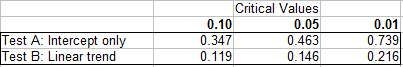



Let residual $S_t = ∑𝜀_t = Y - \hat{Y} = Y - (𝛼 + 𝛽X)$

The drift 𝛼 (constant) and trend 𝛽 (slope) are  fitted by OLS

> $H_0$ : The time seires $y_t$ is trend stationary

> $H_1$ : The time seires $y_t$ has a unit root (is non-stationary)

KPSS-Statistics:

$KPSS = \frac{\sum_{i=1}^{N}S_t^2}{N^2𝜎^2}$

We trade the pair when KPSS-stat < tolerance (set as KPSS_max = 0.463).(i.e. the pair is cointegrated)

Profitable entry is when pair diverge enough from dynamic equilibrium (fair value),


> The tradition pair trade strategy is used in this learning (divergen entry→ convergence stop_loss) (i.e. when return growth of short position is stronger than long position (-ve return> +ve return), the pair position have to close)

> Another strategy (convergen entery→ divergen stop_loss) would be considered and tried afterward (e.g. 2330--FITX; XOM--QG if high correlation)



#### Without $β$ loading position

串流輸出內容已截斷至最後 5000 行。
times_ret2： 0.046088953550541545
day 2020-03-27 00:00:00

old_signal: 1.0 →signal: 0
buy CVX: 1.0 * 36.95000076293945  and sell XOM: 1.0 * 36.95000076293945
long position on CVX and short position on XOM
gross daily return: 0.0%
net daily return: -0.02%
cumulative net return so far: -0.02%
—————————next day—————————
position_XOM: 0
times_ret1： 0.012533365885416758
position_CVX: 0
times_ret2： 0.0070882857242835495
day 2020-03-30 00:00:00

old_signal: 0 →signal: 0
no trading
gross daily return: 0.0%
net daily return: 0.0%
cumulative net return so far: 0.0%
—————————next day—————————
position_XOM: 0
times_ret1： -0.011588159790901997
position_CVX: 0
times_ret2： -0.0538228205238086
day 2020-03-31 00:00:00

old_signal: 0 →signal: 0
no trading
gross daily return: -0.0%
net daily return: -0.0%
cumulative net return so far: 0.0%
—————————next day—————————
position_XOM: -1.0
times_ret1： 0.07647223127982739
position_CVX: 1.0
times_ret2： 0.11026845766041982
day 2020-04-01 00:0

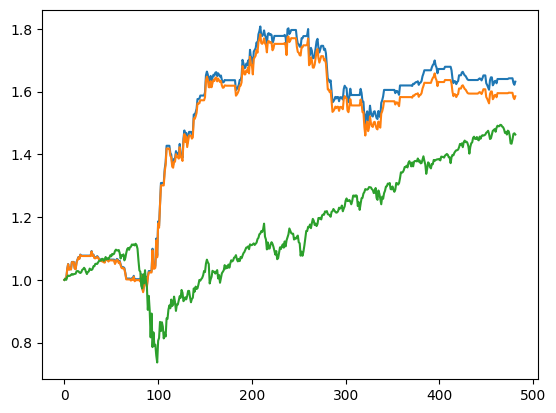

In [ ]:
#specifying rolling window length
window = 21
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463 # tune for more conservative / lenient
#specifying the KPSS test (one-parameter unbiased or two-parameter) (unbiased algo, setting εt as 0, vary one para/ non-unbiased algo, vary both para: const  &slope
unbiased = 1
#specifying whether to perform beta-loading or not
beta_loading = 0
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2019-09-28'
end = '2021-09-28'
#specifying the pair
tickers = ['XOM', 'CVX']
stock1 = tickers[0]
stock2 = tickers[1]
#specifying the market index
market = '^GSPC'
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1] #
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1] #
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal

    print(f'position_{stock1}:',position0)
    print('times_ret1：',(raw_data[stock1][t+1]/raw_data[stock1][t] - 1))
    print(f'position_{stock2}:',position1)
    print('times_ret2：',(raw_data[stock2][t+1]/raw_data[stock2][t] - 1))
    print("===========")
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1

    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

    #interface: reporting daily positions and realised returns
    print('day '+str(raw_data.index[t]))
    print('')
    print('old_signal:',old_position0, '→signal:',position0)
    if position0 == old_position0: #signal == 0: #position0 == 0:
        print('no trading')
    elif  position0 > old_position0: #signal == 1: # position0 > 0:
        print(f'buy {stock1}:',(position0 - old_position0),'*',raw_data[stock1][t],f' and sell {stock2}:',abs(position1 - old_position1),'*',raw_data[stock2][t])
        print('long position on '+stock1+' and short position on '+stock2)
        traded_date = raw_data.index[t]
    else:
        print(f'buy {stock2}:',(position1 - old_position1),'*',raw_data[stock1][t],f' and sell {stock1}:',abs(position0 - old_position0),'*',raw_data[stock1][t])
        print('long position on '+stock2+' and short position on '+stock1)
        traded_date = raw_data.index[t]

    traded_dates = np.append(traded_dates, traded_date)
    print('gross daily return: '+str(round(gross*100,2))+'%')
    print('net daily return: '+str(round(net*100,2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net)*100-100,2))+'%')
    print('————————next day————————')

#building the output dataframe
output0 = pd.DataFrame()
output0['KPSS'] = KPSS_stats
output0['signal'] = signals
output0['gross'] = gross_returns
output0['net'] = net_returns
output0['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)))

> day 2020-07-29 ->30 ; -1 ->1, 1-> -1

#### With $β$ loading position

In [59]:
#moving in a loop through the sample
for t in range(window, len(raw_data)-1): ###
    old_signal = signal
    old_position0 = position0
    old_position1 = position1

    #specifying the subsample
    data = raw_data[t-window:t]

    #stock 2 = a + b* stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[stock2]), sm.add_constant(np.array(data[stock1])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1] ###
    ####

    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[stock2] - b*data[stock1])
            resid = np.array(data[stock2] - (a + b*data[stock1]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[stock2] - b_opt*data[stock1])

    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[stock2] - (a + b*data[stock1]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]


    print('optimal slope:',b_opt)
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[stock2][t] - (a_opt + b_opt*raw_data[stock1][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[stock2][t]/(a_opt + b_opt*raw_data[stock1][t])-1) < entry:
            signal = 0
        #comparing % ($stock2 to dynamic equilibrium -1) diverge  large enough (>entry) and stock1 diverge relatively

        else:
            signal = np.sign(raw_data[stock2][t] - (a_opt + b_opt*raw_data[stock1][t]))
        #signal to decide long/short the pair (stock2 / stock1)

    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets_stk1 = np.array(raw_data[stock1][t-window:t-1])/np.array(raw_data[stock1][t-window+1:t]) - 1
        rets_stk2 = np.array(raw_data[stock2][t-window:t-1])/np.array(raw_data[stock2][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets_stk1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta_stk1 = res.params[1]
        print('beta_stock1:',beta_stk1)
        reg = sm.OLS(rets_stk2, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta_stk2 = res.params[1]
        print('beta_stock2:',beta_stk2)
        position0 = beta_stk2*signal
        position1 = -beta_stk1*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    print(f'position_{stock1}:',position0)
    print('times_ret1：',(raw_data[stock1][t+1]/raw_data[stock1][t] - 1))
    print(f'position_{stock2}:',position1)
    print('times_ret2：',(raw_data[stock2][t+1]/raw_data[stock2][t] - 1))
    print("===========")
    #calculating returns
    gross = position0*(raw_data[stock1][t+1]/raw_data[stock1][t] - 1) + position1*(raw_data[stock2][t+1]/raw_data[stock2][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    #DF_stats = np.append(DF_stats, DF_opt)
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

    #interface: reporting daily positions and realised returns
    print('day '+str(raw_data.index[t]))
    print('')
    print('old_signal:',old_position0, '→signal:',position0)
    if position0 == old_position0: #signal == 0: #position0 == 0:
        print('no trading')
    elif  position0 > old_position0: #signal == 1: # position0 > 0:
        print(f'buy {stock1}:',(position0 - old_position0),'*',raw_data[stock1][t],f' and sell {stock2}:',abs(position1 - old_position1),'*',raw_data[stock2][t])
        print('long position on '+stock1+' and short position on '+stock2)
        traded_date = raw_data.index[t]
    else:
        print(f'buy {stock2}:',(position1 - old_position1),'*',raw_data[stock1][t],f' and sell {stock1}:',abs(position0 - old_position0),'*',raw_data[stock1][t])
        print('long position on '+stock2+' and short position on '+stock1)
        traded_date = raw_data.index[t]

    traded_dates = np.append(traded_dates, traded_date)
    print('gross daily return: '+str(round(gross*100,2))+'%')
    print('net daily return: '+str(round(net*100,2))+'%')
    print('cumulative net return so far: '+str(round(np.prod(1+net)*100-100,2))+'%')
    print('—————————next day—————————')

串流輸出內容已截斷至最後 5000 行。
position_XOM: 1.362925869574978
times_ret1： -0.02329229294481805
position_CVX: -1.454853816867008
times_ret2： -0.003829724001078616
day 2020-07-21 00:00:00

old_signal: 0.0 →signal: 1.362925869574978
buy XOM: 1.362925869574978 * 44.650001525878906  and sell CVX: 1.454853816867008 * 91.38999938964844
long position on XOM and short position on CVX
gross daily return: -2.62%
net daily return: -2.65%
cumulative net return so far: -2.65%
—————————next day—————————
optimal slope: 1.1148600943442921
beta_stock1: 1.4349424610011101
beta_stock2: 1.3395672645429086
position_XOM: 1.3395672645429086
times_ret1： 0.0020637503170894966
position_CVX: -1.4349424610011101
times_ret2： -0.0003295120715641753
day 2020-07-22 00:00:00

old_signal: 1.362925869574978 →signal: 1.3395672645429086
buy CVX: 0.019911355865897873 * 43.61000061035156  and sell XOM: 0.023358605032069324 * 43.61000061035156
long position on CVX and short position on XOM
gross daily return: 0.32%
net daily return: 0

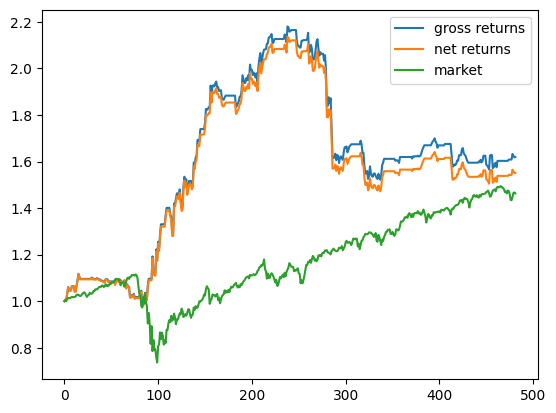

In [ ]:
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)),label='gross returns')
plt.plot(np.append(1,np.cumprod(1+net_returns)),label='net returns')
plt.plot(np.append(1,np.cumprod(1+market_returns)),label='market')
plt.legend()

In [ ]:
raw_data.loc[traded_dates]

,XOM,CVX,market
Date,,,
2019-10-29,68.440002,118.129997,3036.889893
2019-10-30,67.720001,116.360001,3046.770020
2019-10-31,67.570000,116.139999,3037.560059
2019-11-01,69.599998,116.209999,3066.909912
2019-11-04,71.669998,121.570000,3078.270020
...,...,...,...
2021-09-16,55.820000,97.320000,4473.750000
2021-09-21,53.639999,94.849998,4354.189941
2021-09-22,55.209999,97.639999,4395.640137


In [ ]:
#building the output dataframe
output = pd.DataFrame()
#output['DF'] = DF_stats
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns

In [ ]:
''' KPSS_max= 0.463, fee=0.0001, entry=0.02, stop_loss= -0.05
signal = np.sign( CVX - fair_val(XOM) )
position0 = beta_stk2 * signal
position1 = beta_stk1 * -signal
gross = position0* (XOM_ret) + position1* (CVX_ret)
'''
output.set_index(raw_data[21:-1].index)#traded_dates)

,KPSS,signal,gross,net,market
Date,,,,,
2019-10-29,0.076902,1.0,0.007012,0.006762,0.003253
2019-10-30,0.055737,1.0,-0.000139,-0.000151,-0.003023
2019-10-31,0.095836,1.0,0.024708,0.024675,0.009662
2019-11-01,0.124835,-1.0,0.028176,0.027773,0.003704
2019-11-04,0.067337,-1.0,-0.012596,-0.012616,-0.001186
...,...,...,...,...,...
2021-09-20,0.150360,0.0,-0.000000,-0.000000,-0.000812
2021-09-21,0.066362,-1.0,0.014927,0.014545,0.009520
2021-09-22,0.117177,-1.0,-0.004776,-0.004815,0.012135


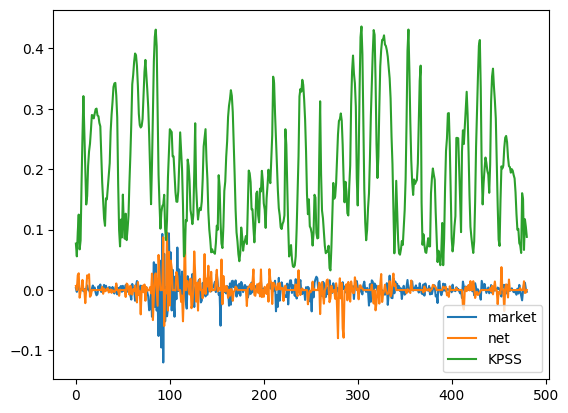

In [53]:
plt.plot(output['market'],label='market')
plt.plot(output['net'],label='net')
plt.plot(output['KPSS'],label='KPSS')
plt.legend()

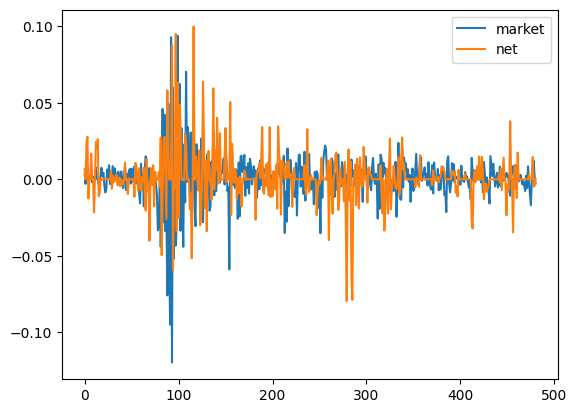

In [51]:
plt.plot(output['market'],label='market')
plt.plot(output['net'],label='net')
#plt.plot(output['KPSS'],label='KPSS')
plt.legend()

## *Statistical Tests*

In [ ]:
window = 21
t = 22
data = raw_data[t-window:t]
data

,XOM,CVX,market
Date,,,
2019-10-01,68.949997,116.010002,2940.250000
2019-10-02,67.150002,112.290001,2887.610107
2019-10-03,67.980003,113.150002,2910.629883
2019-10-04,68.970001,113.849998,2952.010010
2019-10-07,68.019997,113.260002,2938.790039
2019-10-08,66.699997,111.709999,2893.060059
2019-10-09,67.440002,113.139999,2919.399902
2019-10-10,68.250000,114.589996,2938.129883
2019-10-11,68.980003,116.150002,2970.270020


#### $I(1)$ Trail - optimal DF-stat for repective sequences (1-lag difference staionary)

In [ ]:

def unit_root(b):
    a = np.average(np.array(data[stock1][:-1]) - b*np.array(data[stock1][:-1]))
    yhat_t = a + b*data[stock1][:-1]
    ts = np.array(yhat_t - data[stock1][:-1])
    ts_diff = ts[1:] - ts[:-1] #ts.diff(periods=1).dropna()
    reg = sm.OLS(ts_diff, ts[:-1]) #
    res = reg.fit()
    #a0 = res.params[0]
    #b0 = res.params[1] ###
    return res.params[0]/res.bse[0]

res1 = spop.minimize(unit_root, data[stock1][-1]/data[stock1][-2], method='Nelder-Mead') # b = stk1/stk2 <1
DF_opt = res1.fun #
b_opt = float(res1.x)
#a_opt = np.average(data[stock1][1:] - b_opt*data[stock1][:-1])

DF_opt, b_opt, a_opt

(-2.6558594442666923, 1.0212344751434461, -46.761817838075466)

-> stock 2 = a + b* stock 1 + ɛ

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

for t in range(window, len(raw_data)-1):

  data = raw_data[t-window:t]

  stock2_ADF = adfuller(data[stock2])
  if
  print('P value for the Augmented Dickey-Fuller Test is', stock2_ADF[1])
  stock1_ADF = adfuller(data[stock1])
  print('P value for the Augmented Dickey-Fuller Test is', stock1_ADF[1])
  stock2_1_ADF = adfuller(data[stock2], maxlag = 1)
  print('P value for the Augmented Dickey-Fuller Test is', stock2_1_ADF[1])
  stock1_1_ADF = adfuller(data[stock1], maxlag = 1)
  print('P value for the Augmented Dickey-Fuller Test is', stock1_1_ADF[1])
  spread_ADF = adfuller(data[stock2] - data[stock1]) ###
  print('P value for the Augmented Dickey-Fuller Test is', spread_ADF[1])
  Ratio_ADF = adfuller(data[stock1] / data[stock2])
  print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])




#### Granger Causality Test (if both series are stationary $I(1)$)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
gc_df = pd.concat([data[stock2],data[stock1]],1) # stock2 granger caused by stock1, using stationary
gc_res = grangercausalitytests(gc_df,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8414  , p=0.0419  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=5.6958  , p=0.0170  , df=1
likelihood ratio test: chi2=5.0119  , p=0.0252  , df=1
parameter F test:         F=4.8414  , p=0.0419  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1578  , p=0.0121  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=16.7141 , p=0.0002  , df=2
likelihood ratio test: chi2=11.9910 , p=0.0025  , df=2
parameter F test:         F=6.1578  , p=0.0121  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6904  , p=0.0241  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=23.0257 , p=0.0000  , df=3
likelihood ratio test: chi2=14.8289 , p=0.0020  , df=3
parameter F test:         F=4.6904  , p=0.0241  , df_denom=11, df_num=3


<ipython-input-24-077e28b74bcf>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  gc_df = pd.concat([data[stock2],data[stock1]],1) # 1st column granger caused by 2nd


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
gc_df = pd.concat([data[stock1],data[stock2]],1) # 1st column granger caused by 2nd
gc_res = grangercausalitytests(gc_df,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6181  , p=0.2205  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=1.9037  , p=0.1677  , df=1
likelihood ratio test: chi2=1.8184  , p=0.1775  , df=1
parameter F test:         F=1.6181  , p=0.2205  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8846  , p=0.0893  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=7.8296  , p=0.0199  , df=2
likelihood ratio test: chi2=6.5562  , p=0.0377  , df=2
parameter F test:         F=2.8846  , p=0.0893  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9293  , p=0.0811  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=14.3801 , p=0.0024  , df=3
likelihood ratio test: chi2=10.5691 , p=0.0143  , df=3
parameter F test:         F=2.9293  , p=0.0811  , df_denom=11, df_num=3


<ipython-input-25-1fc296d6ddc3>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  gc_df = pd.concat([data[stock1],data[stock2]],1) # 1st column granger caused by 2nd


stock 2 = a + b* stock 1 + ɛ

#### cointgration unit test (if both series are non-stionary)

In [ ]:
from statsmodels.tsa.stattools import adfuller
data = raw_data[22-21:22]
reg = sm.OLS(np.array(data[stock2]), sm.add_constant(np.array(data[stock1])))
res = reg.fit()
a0 = res.params[0]
b0 = res.params[1] ###

adfuller(res.resid,1)

(-0.7108101207222032,
 0.8439295675234719,
 0,
 20,
 {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125},
 50.21533978494474)

In [ ]:
import statsmodels.tsa.stattools as ts
ts.coint(data[stock2],data[stock1]),ts.coint(data[stock1],data[stock2]),ts.coint(data[stock2],data[stock1],'ct'),ts.coint(data[stock1],data[stock2],'ct')

((0.1403048744047897,
  0.9886785122195779,
  array([-4.5278525, -3.6586925, -3.26331  ])),
 (-1.406545716386021,
  0.7952607466030888,
  array([-4.5278525, -3.6586925, -3.26331  ])),
 (-4.2077856628601635,
  0.014700930165389516,
  array([-5.1887525, -4.286285 , -3.8664935])),
 (-1.0730567209798116,
  0.9729773364221848,
  array([-5.1887525, -4.286285 , -3.8664935])))

#### DeTrenidng by difference

In [ ]:
from statsmodels.tsa.stattools import kpss
data = raw_data[22-21:22]
#data_diff = data.diff(periods=1).dropna()
#kpss(data[stock2]/data[stock1])[0]<kpss(data[stock2]/data[stock1])[-1]['2.5%'],kpss(data[stock2]/data[stock1]),kpss(data[stock1] / data[stock2]),kpss(data[stock2]/data[stock1],'ct'),kpss(data[stock1]/data[stock2],'ct')
kpss(data[stock2]),kpss(data[stock1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


((0.6431534328690818,
  0.018713324284628928,
  2,
  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}),
 (0.34086033190457454,
  0.1,
  1,
  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}))

In [ ]:
from statsmodels.tsa.stattools import adfuller
data = raw_data[22-21:22]
#data_diff = data.diff(periods=1).dropna()
adfuller(data[stock2],maxlag = 1), adfuller(data[stock1],maxlag = 1)#,adfuller(data[stock1].diff(periods=1).dropna(),0)
#adfuller(data[stock2]/data[stock1],1),adfuller(data[stock1] / data[stock2],1)
#adfuller(data[stock2]/data[stock1],1,'ct'),adfuller(data[stock1] / data[stock2],1,'ct')

((-0.4708125694294739,
  0.8975874825637651,
  5,
  15,
  {'1%': -3.9644434814814815,
   '5%': -3.0849081481481484,
   '10%': -2.6818144444444445},
  27.551347277979634),
 (-3.026393795317774,
  0.03250199369678011,
  1,
  19,
  {'1%': -3.8326031418574136,
   '5%': -3.0312271701414204,
   '10%': -2.655519584487535},
  39.96433304340092))

In [ ]:
DF_threshold = -2.567 # DF-critical: 10% = -1.161, 5% = -1.941, 1% = -2.567

for t in range(window, len(raw_data)-1):

  data = raw_data[t-window:t]

  #adfuller(data[stock2],maxlag = 1), adfuller(data[stock1],maxlag = 1)

  def coin_unit_root(b):
      a = np.average(data[stock2] - b*data[stock1]) #np.average(data[stock1][t-window:t] - b*data[stock2][t-window:t])
      fair_value = a + b*data[stock2]
      diff = np.array(data[stock1] - fair_value)
      diff_diff = diff[1:] - diff[:-1] #(df).diff(periods=1).dropna()
      reg = sm.OLS(diff_diff, diff[:-1]) #sm.add_constant(diff[:-1]))
      res = reg.fit()
      #a0 = res.params[0]
      #b0 = res.params[1] ###
      return res.params[0]/res.bse[0]

  res1 = spop.minimize(coin_unit_root, data[stock1][t]/data[stock2][t], method='Nelder-Mead') # b = stk1/stk2 <1
  DF_opt = res1.fun #
  b_opt = float(res1.x)
  a_opt = np.average(data[stock1] - b_opt*data[stock2])
  #simulating trading
  fair_value = a_opt + b_opt*data[stock2][t]

  #
  if DF_opt > DF_threshold:
      signal = 0
  else: #
      signal = np.sign(fair_value - data[stock2][t])

  position0 = signal
  position1 = -signal
  gross = position0*(raw_data[stock1][t+1]/raw_data[stock1][t] - 1) + position1*(raw_data[stock2][t+1]/raw_data[stock2][t] - 1)
  #gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]

  DF_stats = np.append(DF_stats, DF_opt)
  gross_returns = np.append(gross_returns, gross)




IndexError: ignored

## $Stock_2 = a + b* Stock_1$

##### Trail

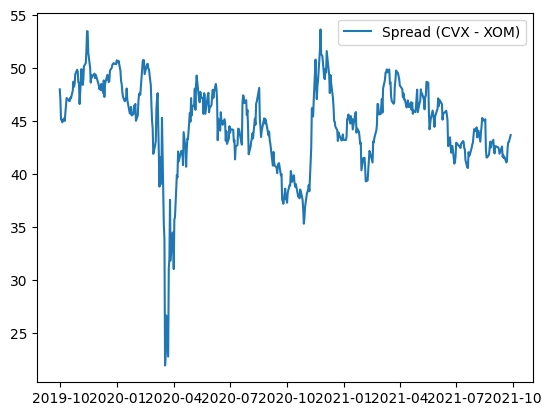

In [ ]:
spread = raw_data['CVX']-raw_data['XOM']
plt.plot(raw_data['CVX']-raw_data['XOM'], label = 'Spread (CVX - XOM)')
plt.legend()

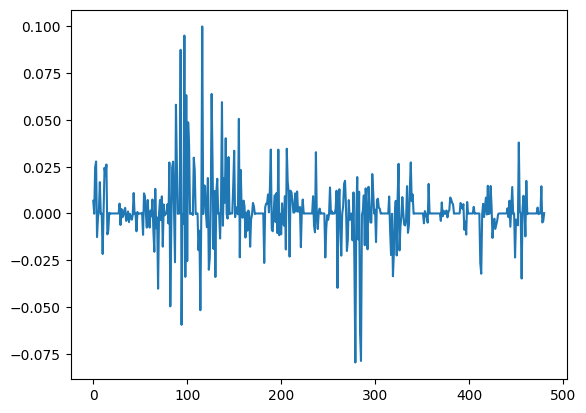

In [ ]:
plt.plot(output['net'])

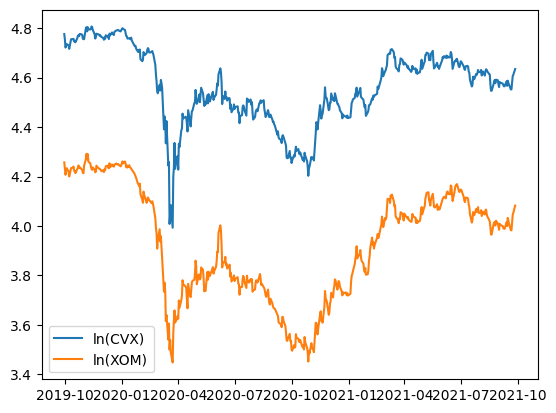

In [ ]:
#plt.plot(raw_data[stock2],label='CVX')
#plt.plot(raw_data[stock1],label='XOM')
plt.plot(np.log(raw_data[stock2]),label='ln(CVX)')
plt.plot(np.log(raw_data[stock1]),label='ln(XOM)')
plt.legend()

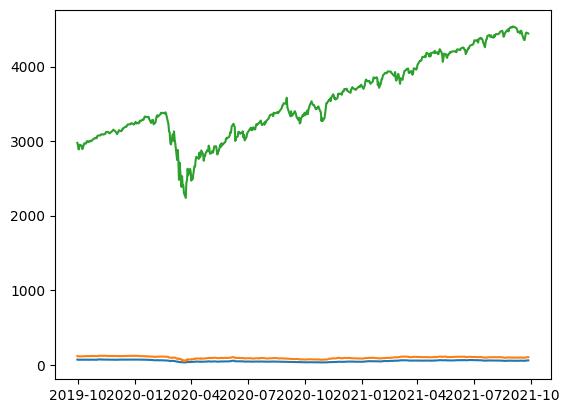

In [ ]:
plt.plot(raw_data)
        signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
        gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)

In [ ]:
#raw_data[raw_data.index == traded_dates]
raw_data
data
#np.average(np.array(data[stock1][1:]) - data[stock1][-1]/data[stock1][-2]*np.array(data[stock1][:-1]))
#data[stock1].diff(periods=1).dropna()

,XOM,CVX,market
Date,,,
2019-10-01,68.949997,116.010002,2940.250000
2019-10-02,67.150002,112.290001,2887.610107
2019-10-03,67.980003,113.150002,2910.629883
2019-10-04,68.970001,113.849998,2952.010010
2019-10-07,68.019997,113.260002,2938.790039
2019-10-08,66.699997,111.709999,2893.060059
2019-10-09,67.440002,113.139999,2919.399902
2019-10-10,68.250000,114.589996,2938.129883
2019-10-11,68.980003,116.150002,2970.270020


#### Rolling window length: 252

In [ ]:
#specifying rolling window length
window = 252

In [ ]:
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]

    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])

    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]

    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) # stocks diverge enough (>entry) to decide long/short the pair (stock2 to stock1)
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        print('beta_stock1:',beta0)
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        print('beta_stock2:',beta1)
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    print('position_stk1:',position0)
    print('times：',(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1))
    print('position_stk2:',position1)
    print('times：',(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1))
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

beta_stock1: 1.089061872007094
beta_stock2: 1.3700768368887384
position_stk1: -1.3700768368887384
times： 0.0014586655057879927
position_stk2: 1.089061872007094
times： 0.0013907993323909462
beta_stock1: 1.089223481904165
beta_stock2: 1.3706261245612312
position_stk1: -1.3706261245612312
times： -0.03495487034474731
position_stk2: 1.089223481904165
times： -0.021944469875759598
beta_stock1: 1.0884271737531925
beta_stock2: 1.3693547616627324
position_stk1: -1.3693547616627324
times： -0.004527664384027741
position_stk2: 1.0884271737531925
times： 0.010934454593617193
beta_stock1: 1.0863715433734773
beta_stock2: 1.3682614083210844
position_stk1: -1.3682614083210844
times： 0.02304433434746289
position_stk2: 1.0863715433734773
times： 0.02121076633026875
beta_stock1: 1.0852194034562825
beta_stock2: 1.3671317313746936
position_stk1: -1.3671317313746936
times： -0.01037351130429065
position_stk2: 1.0852194034562825
times： -0.005501979549863645
beta_stock1: 1.0860343232169174
beta_stock2: 1.367227954

In [ ]:
#building the output dataframe
output252 = pd.DataFrame()
output252['KPSS'] = KPSS_stats
output252['signal'] = signals
output252['gross'] = gross_returns
output252['net'] = net_returns
output252['market'] = market_returns

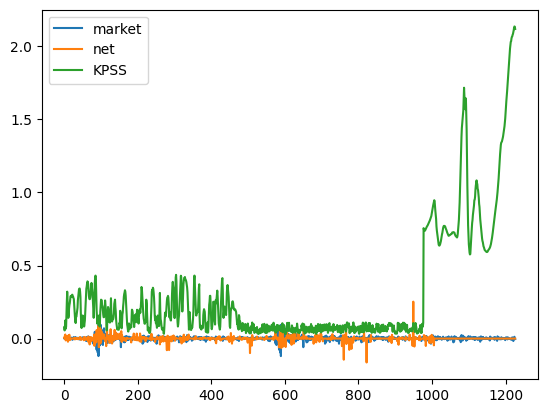

In [ ]:
plt.plot(output252['market'],label='market')
plt.plot(output252['net'],label='net')
plt.plot(output252['KPSS'],label='KPSS')
plt.legend()

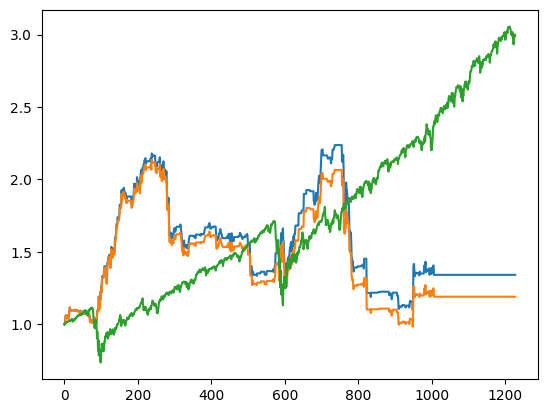

In [ ]:
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)))

#### Ref：

In [ ]:
'position0 -> position_stk1'
'position1 -> position_stk2'

'rets0 -> rets_stk1'
'rets1 -> rets_stk2'

In [ ]:
output0.set_index(raw_data[21:-1].index)

,KPSS,signal,gross,net,market
Date,,,,,
2019-10-29,0.076902,1.0,0.004463,0.004263,0.003253
2019-10-30,0.055737,1.0,-0.000324,-0.000324,-0.003023
2019-10-31,0.095836,1.0,0.029440,0.029440,0.009662
2019-11-01,0.124835,-1.0,0.016382,0.015982,0.003704
2019-11-04,0.067337,-1.0,-0.016769,-0.016769,-0.001186
...,...,...,...,...,...
2021-09-20,0.150360,0.0,0.000000,0.000000,-0.000812
2021-09-21,0.066362,-1.0,0.000146,-0.000054,0.009520
2021-09-22,0.117177,-1.0,-0.009086,-0.009086,0.012135


In [ ]:
#moving in a loop through the sample
for t in range(window, len(raw_data)-1): ###
    old_signal = signal
    old_position0 = position0
    old_position1 = position1

    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    ####
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1] ###
    ####

    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]])

    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]

    ##DF unit test # Detrending by Differencing

    print('optimal slope:',b_opt)
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) # stocks diverge enough (>entry) to decide long/short the pair (stock2 to stock1)
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        print('beta_stock1:',beta0)
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        print('beta_stock2:',beta1)
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    print('position_stk1:',position0)
    print('times_ret1：',(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1))
    print('position_stk2:',position1)
    print('times_ret2：',(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1))
    print("===========")
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

beta_stock1: 1.3083753432413479
beta_stock2: 1.1969025037437193
position_stk1: 1.1969025037437193
times_ret1： -0.010520181107818383
position_stk2: -1.3083753432413479
times_ret2： -0.014983464693301585
beta_stock1: 1.2523175526467116
beta_stock2: 1.1317384916341702
position_stk1: 1.1317384916341702
times_ret1： -0.0022150254455850504
position_stk2: -1.2523175526467116
times_ret2： -0.0018906945647055862
beta_stock1: 1.207559744377483
beta_stock2: 0.8466340982240688
position_stk1: 0.8466340982240688
times_ret1： 0.030042900524866578
position_stk2: -1.207559744377483
times_ret2： 0.0006027182296546307
beta_stock1: 1.1463540563905754
beta_stock2: 0.8304213476789244
position_stk1: -0.8304213476789244
times_ret1： 0.02974137557767187
position_stk2: 1.1463540563905754
times_ret2： 0.04612340291350825
beta_stock1: 1.3329309260757958
beta_stock2: 0.8405208043508898
position_stk1: -0.8405208043508898
times_ret1： 0.01981300690978105
position_stk2: 1.3329309260757958
times_ret2： 0.0030435366250789464
be